cat: (100, 16384)
dog: (100, 16384)
bird: (100, 16384)
Sample cat images:


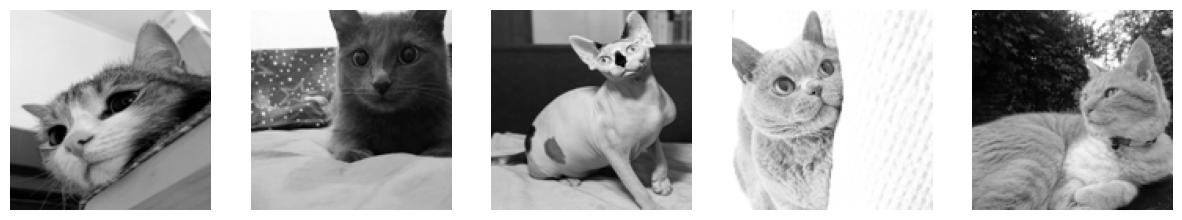

Sample dog images:


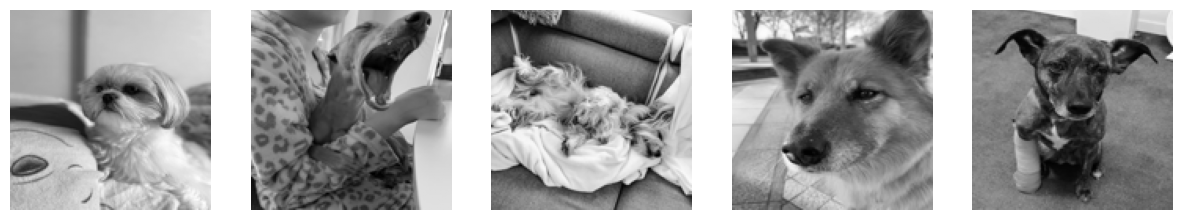

Sample bird images:


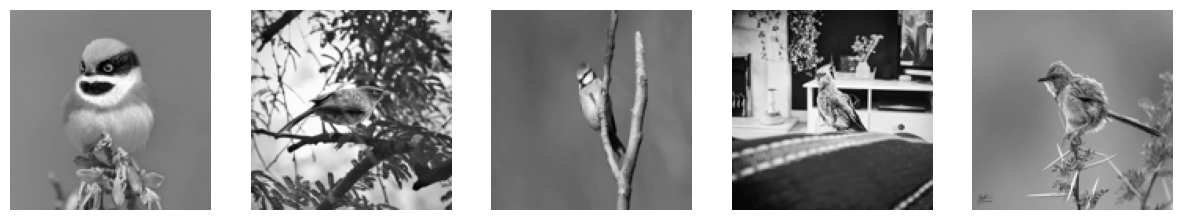

In [1]:
# DS623 Team Project - Image Processing and PCA (NumPy only)

# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Dataset path and categories (match your folder names exactly)
dataset_path = './catdogbird_dataset'
categories = ['cat', 'dog', 'bird']

# Function to load and preprocess images (grayscale, resize, flatten)
def load_images(folder, size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            path = os.path.join(folder, filename)
            img = Image.open(path).convert('L')  # Convert to grayscale
            img = img.resize(size)
            images.append(np.array(img).flatten())
    return np.array(images)

# Load the dataset into a dictionary
data = {}
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    data[category] = load_images(folder_path)

# Check shape of loaded data
for category in categories:
    print(f"{category}: {data[category].shape}")

# Display sample images
def show_samples(category, num_samples=5):
    images = data[category][:num_samples]
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i, img in enumerate(images):
        axs[i].imshow(img.reshape(128, 128), cmap='gray')
        axs[i].axis('off')
    plt.show()

# Show 5 sample images from each category
for category in categories:
    print(f"Sample {category} images:")
    show_samples(category)